In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install gdown

In [4]:
!if [ ! -e "stocks" ]; then \
  gdown --id '1AzIra9nVKVnXEg4RDi6Dtqtr9nZergzH' --output "stocks.zip" ;\
  unzip -q "stocks.zip" ;\
fi

!rm stocks.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1AzIra9nVKVnXEg4RDi6Dtqtr9nZergzH
From (redirected): https://drive.google.com/uc?id=1AzIra9nVKVnXEg4RDi6Dtqtr9nZergzH&confirm=t&uuid=ad9ff192-cd1f-42b8-8568-c63a3515bbdb
To: /content/stocks.zip
100% 52.4M/52.4M [00:00<00:00, 58.4MB/s]


In [5]:
!if [ ! -e "stock_num.txt" ]; then \
  gdown --id '1uVUmGb5TG1XNPKfiipZZ8CZZvHkiz33_' --output "stock_num.txt" ;\
fi

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1uVUmGb5TG1XNPKfiipZZ8CZZvHkiz33_
To: /content/stock_num.txt
100% 12.0k/12.0k [00:00<00:00, 28.5MB/s]


In [6]:
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset, SubsetRandomSampler

from transformers import get_scheduler
from accelerate import Accelerator, DistributedDataParallelKwargs, InitProcessGroupKwargs

from datetime import timedelta

# KFold
# KFOLD Reference: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
from sklearn.model_selection import KFold

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

In [7]:
stock_num = list()
with open('stock_num.txt') as f:
    lines = f.readlines()
    for line in lines:
        stock_num.append(line.strip())

In [8]:
stock_num_mod = []
for i in range(len(stock_num)):
    path = 'stocks/' + stock_num[i] + '.csv'
    try:
        stock = pd.read_csv(path)
        if len(stock) >= 500:
            stock_num_mod.append(stock_num[i])
    except:
        print(path, " is empty and has been skipped.")

print(len(stock_num_mod))

1954


In [9]:
def same_seed(seed):
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set))
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()
    return preds

In [94]:
class Stock:
    def __init__(self, *stock_numbers):
        self.stock_numbers = stock_numbers
    def scrape(self):
        for stock_number in self.stock_numbers:
            path = 'stocks/' + stock_number + '.csv'
            data = pd.read_csv(path)

            incl = list()
            prel = list()
            max9 = list()
            min9 = list()
            rsvl = list()
            kl = list()
            dl = list()
            jl = list()
            avgl = list()
            biasl = list()
            for i in range(8):
                max9.append("0")
                min9.append("0")
                rsvl.append("0")

            for i in range(7):
                kl.append("0")
                dl.append("0")
                jl.append("0")

            incl.append("0")
            avgl.append("0")
            biasl.append("0")

            kl.append("50")
            dl.append("50")
            jl.append("50")

            for i in range(len(data)-8):
                dmax = data[['max']].iloc[i:i+9].max().to_string(index=False)
                max9.append(dmax)

                dmin = data[['min']].iloc[i:i+9].min().to_string(index=False)
                min9.append(dmin)

            for i in range(8, len(data)):
                close = data[['close']].iloc[i].to_string(index=False)
                if float(max9[i])-float(min9[i]) != 0.0:
                    rsv = ((float(close)-float(min9[i]))/(float(max9[i])-float(min9[i])))
                else: rsv = float(kl[i-1])/100
                k = ((2/3)*float(kl[i-1]))+((100/3)*rsv)
                d = ((2/3)*float(dl[i-1]))+((1/3)*k)
                j = ((3*d)-(2*k))
                rsvl.append(rsv)
                kl.append(k)
                dl.append(d)
                jl.append(j)

            for i in range(len(data)-1):
                close1 = data[['close']].iloc[i].to_string(index=False)
                close2 = data[['close']].iloc[i+1].to_string(index=False)
                if float(close1) != 0.0:
                    inc = (100*((float(close2)-float(close1))/float(close1)))
                    incl.append(inc)
                    prel.append(inc)
                else:
                    incl.append("0")
                    prel.append("0")
                avg = data[['close']].iloc[i:i+2].mean().to_string(index=False)


                avgl.append(avg)

            for i in range(1, len(data)):
                close = data[['close']].iloc[i].to_string(index=False)
                if float(avgl[i]) != 0.0:
                    bias = (100*((float(close)-float(avgl[i]))/float(avgl[i])))
                    biasl.append(bias)
                else: biasl.append("0")

            prel.append("0")

            k1l = kl.copy()
            d1l = dl.copy()
            j1l = jl.copy()
            k2l = kl.copy()
            d2l = dl.copy()
            j2l = jl.copy()

            k1l.insert(0, "0")
            d1l.insert(0, "0")
            j1l.insert(0, "0")
            k1l.pop()
            d1l.pop()
            j1l.pop()

            for i in range(2):
                k2l.insert(0, "0")
                d2l.insert(0, "0")
                j2l.insert(0, "0")
                k2l.pop()
                d2l.pop()
                j2l.pop()

            data['inc'] = incl
            data['max9'] = max9
            data['min9'] = min9
            data['rsv'] = rsvl
            data['k'] = kl
            data['d'] = dl
            data['j'] = jl
            data['avg'] = avgl
            data['bias'] = biasl
            data['k1'] = k1l
            data['d1'] = d1l
            data['j1'] = j1l
            data['k2'] = k2l
            data['d2'] = d2l
            data['j2'] = j2l

            if len(data)>=160:
                ema12l = list()
                ema26l = list()
                difl = list()
                macdl = list()
                dif_macdl = list()

                for i in range(11):
                    ema12l.append("0")

                for i in range(25):
                    ema26l.append("0")
                    difl.append("0")

                di12 = (float(data[['max']].iloc[:12].mean().to_string(index=False))+float(data[['min']].iloc[:12].mean().to_string(index=False))+float(data[['close']].iloc[:12].mean().to_string(index=False))*2)/4
                di26 = (float(data[['max']].iloc[:26].mean().to_string(index=False))+float(data[['min']].iloc[:26].mean().to_string(index=False))+float(data[['close']].iloc[:26].mean().to_string(index=False))*2)/4


                ema12l.append(di12)
                ema26l.append(di26)

                for i in range(12, len(data)):
                    close = data[['close']].iloc[i].to_string(index=False)
                    max1 = data[['max']].iloc[i].to_string(index=False)
                    min1 = data[['min']].iloc[i].to_string(index=False)
                    di = (float(close)*2+float(max1)+float(min1))/4
                    ema12today = (float(ema12l[i-1])*11 + di*2)/13
                    ema12l.append(ema12today)

                for i in range(26, len(data)):
                    close = data[['close']].iloc[i].to_string(index=False)
                    max1 = data[['max']].iloc[i].to_string(index=False)
                    min1 = data[['min']].iloc[i].to_string(index=False)
                    di = (float(close)*2+float(max1)+float(min1))/4
                    ema26today = (float(ema26l[i-1])*25 + di*2)/27
                    ema26l.append(ema26today)

                for i in range(25, len(data)):
                    difl.append(float(ema12l[i])-float(ema26l[i]))

                for i in range(33):
                    macdl.append("0")

                macdl.append(sum(difl[25:34])/9)

                for i in range(34, len(data)):
                    macdtoday = (float(macdl[i-1])*8 + float(difl[i])*2)/10
                    macdl.append(macdtoday)

                for i in range(len(data)):
                    dif_macdl.append(float(difl[i])-float(macdl[i]))


                data['ema12'] = ema12l
                data['ema26'] = ema26l
                data['dif'] = difl
                data['macd'] = macdl
                data['dif-macd'] = dif_macdl
                data['pre'] = prel

                data['rsi'] = self.compute_rsi(data['close'], period=14)

        return data.iloc[40:]
    def compute_rsi(self, close, period=14):
        delta = close.diff()

        gain = delta.where(delta > 0, 0.0)
        loss = -delta.where(delta < 0, 0.0)

        # Initialize average gain/loss
        avg_gain = gain.rolling(window=period, min_periods=period).mean().copy()
        avg_loss = loss.rolling(window=period, min_periods=period).mean().copy()

        rsi = [np.nan] * len(close)

        for i in range(period, len(close)):
            if i == period:
                rs = avg_gain.iloc[i] / avg_loss if avg_loss.iloc[i].item() != 0 else np.inf
            else:
                gain_val = gain.iloc[i]
                loss_val = loss.iloc[i]
                avg_gain.iloc[i] = (avg_gain.iloc[i - 1] * (period - 1) + gain_val) / period
                avg_loss.iloc[i] = (avg_loss.iloc[i - 1] * (period - 1) + loss_val) / period
                rs = avg_gain.iloc[i] / avg_loss.iloc[i] if avg_loss.iloc[i].item() != 0 else np.inf

            rsi[i] = 100 - (100 / (1 + rs))

        return rsi

In [95]:
stock = Stock('2330')
data = stock.scrape()

In [96]:
kdif = list()
kdif2 = list()
for i in range(len(data)):
    k = data['k'].iloc[i]
    k1 = data['k1'].iloc[i]
    k2 = data['k2'].iloc[i]
    kdif.append(float(k) - float(k1))
    kdif2.append(float(k1) - float(k2))
data['kdif'] = kdif
data['kdif2'] = kdif2

In [97]:
data.head()

,date,stock_id,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover,...,j2,ema12,ema26,dif,macd,dif-macd,pre,rsi,kdif,kdif2
40,2020-03-10,2330,74869130,22727941511,301.5,309.0,301.0,307.0,1.5,30268,...,22.38182,316.587009,321.740493,-5.153484,-3.833941,-1.319543,-1.628664,35.878985,-2.454925,-15.682388
41,2020-03-11,2330,64923710,19913151529,309.0,310.5,302.0,302.0,-5.0,27176,...,46.285988,314.669776,320.435641,-5.765865,-4.220326,-1.545539,-2.649007,32.852509,-8.303283,-2.454925
42,2020-03-12,2330,114173351,33544278206,299.0,299.0,287.0,294.0,-8.0,56989,...,43.767176,311.412888,318.440409,-7.027521,-4.781765,-2.245756,-1.360544,28.683491,-0.885950,-8.303283
43,2020-03-13,2330,151268148,42448997546,275.0,294.0,272.5,290.0,-4.0,71990,...,47.118017,307.599367,316.083712,-8.484345,-5.522281,-2.962064,-4.655172,26.848871,4.329888,-0.885950
44,2020-03-16,2330,103933228,29343288916,285.0,291.0,275.5,276.5,-13.5,51292,...,39.166817,303.334079,313.401585,-10.067505,-6.431326,-3.636180,-3.074141,21.784552,-5.524623,4.329888


In [98]:
column_names = list(data.columns.values)
column_names

['date',
 'stock_id',
 'Trading_Volume',
 'Trading_money',
 'open',
 'max',
 'min',
 'close',
 'spread',
 'Trading_turnover',
 'inc',
 'max9',
 'min9',
 'rsv',
 'k',
 'd',
 'j',
 'avg',
 'bias',
 'k1',
 'd1',
 'j1',
 'k2',
 'd2',
 'j2',
 'ema12',
 'ema26',
 'dif',
 'macd',
 'dif-macd',
 'pre',
 'rsi',
 'kdif',
 'kdif2']

In [99]:
data.shape

(1303, 34)

In [100]:
data.dtypes

,0
date,object
stock_id,int64
Trading_Volume,int64
Trading_money,int64
open,float64
max,float64
min,float64
close,float64
spread,float64
Trading_turnover,int64


In [101]:
data.drop('date', inplace=True, axis=1)
data.drop('stock_id', inplace=True, axis=1)

In [102]:
data = data.astype({'inc':'float','pre':'float','max9':'float','min9':'float','rsv':'float','k':'float','d':'float','j':'float','avg':'float','bias':'float','ema12':'float','ema26':'float','dif':'float','macd':'float','k1':'float','d1':'float','j1':'float','k2':'float','d2':'float','j2':'float'})

In [103]:
data.dtypes

,0
Trading_Volume,int64
Trading_money,int64
open,float64
max,float64
min,float64
close,float64
spread,float64
Trading_turnover,int64
inc,float64
max9,float64


In [104]:
data.corr()

,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover,inc,max9,...,j2,ema12,ema26,dif,macd,dif-macd,pre,rsi,kdif,kdif2
Trading_Volume,1.000000,0.784911,-0.001477,0.005304,-0.009041,-0.002752,-0.036852,0.633129,0.003651,0.030184,...,0.058973,-0.001150,-0.007385,0.097885,0.120992,-0.054915,0.010595,0.080790,-0.064406,-0.032772
Trading_money,0.784911,1.000000,0.555472,0.561662,0.549328,0.554518,-0.047132,0.752003,-0.010888,0.582468,...,0.122078,0.556613,0.548215,0.226585,0.260391,-0.063756,-0.002200,0.135903,-0.070865,-0.036720
open,-0.001477,0.555472,1.000000,0.999731,0.999737,0.999395,0.022395,0.291561,0.009150,0.995967,...,0.122364,0.996323,0.991221,0.249405,0.258459,0.020461,-0.027373,0.120280,-0.013311,0.002043
max,0.005304,0.561662,0.999731,1.000000,0.999670,0.999712,0.029010,0.295556,0.015543,0.996492,...,0.123453,0.996454,0.991258,0.250896,0.260484,0.019038,-0.027659,0.122130,-0.009570,-0.000669
min,-0.009041,0.549328,0.999737,0.999670,1.000000,0.999700,0.028162,0.285271,0.014583,0.995651,...,0.122240,0.996303,0.991128,0.250545,0.259278,0.021721,-0.028539,0.122205,-0.009263,0.001413
close,-0.002752,0.554518,0.999395,0.999712,0.999700,1.000000,0.040660,0.286236,0.026595,0.995682,...,0.123201,0.995983,0.990690,0.252351,0.260978,0.022422,-0.029886,0.127178,0.000137,0.000316
spread,-0.036852,-0.047132,0.022395,0.029010,0.028162,0.040660,1.000000,-0.357508,0.932100,-0.001377,...,0.026080,-0.007237,-0.011431,0.064743,0.018379,0.162130,-0.018161,0.324828,0.592061,-0.016762
Trading_turnover,0.633129,0.752003,0.291561,0.295556,0.285271,0.286236,-0.357508,1.000000,-0.299514,0.340354,...,-0.038485,0.322945,0.334384,-0.125125,-0.052462,-0.258799,0.008609,-0.226959,-0.201866,-0.085694
inc,0.003651,-0.010888,0.009150,0.015543,0.014583,0.026595,0.932100,-0.299514,1.000000,-0.012586,...,0.027073,-0.019467,-0.023441,0.059208,0.011959,0.163877,-0.012675,0.359911,0.628801,-0.007882
max9,0.030184,0.582468,0.995967,0.996492,0.995651,0.995682,-0.001377,0.340354,-0.012586,1.000000,...,0.122380,0.998284,0.995103,0.219512,0.243795,-0.034509,-0.024326,0.073766,-0.036529,-0.029966


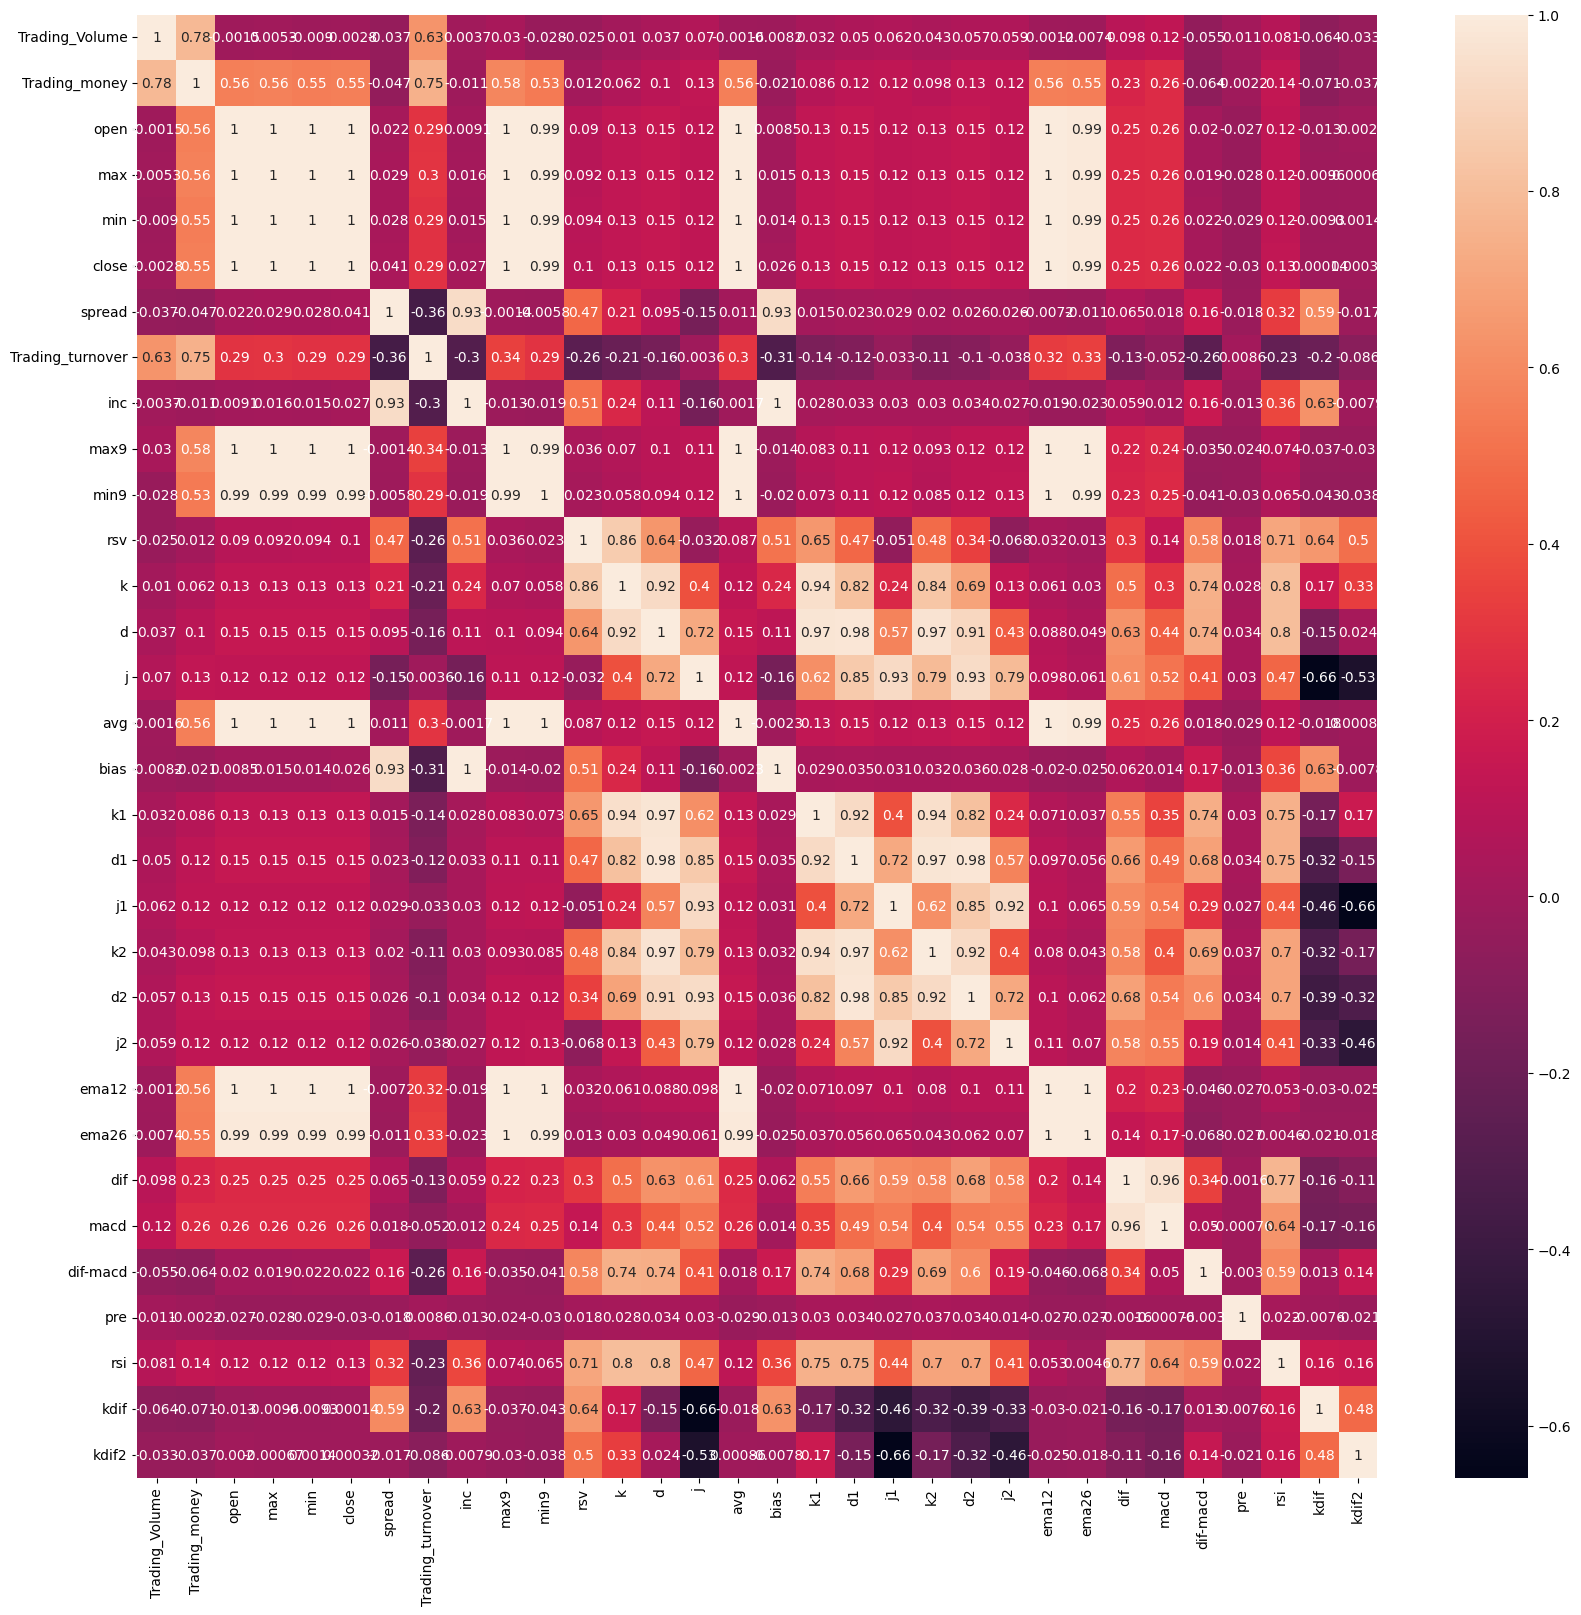

In [105]:
plt.figure(figsize=(20, 19))
p = sns.heatmap(data.corr(), annot=True)

In [106]:
#testing
#x = np.empty([10 * 200, 5 * 5], dtype = float)
#y = np.empty([10 * 200, 1], dtype = float)
#xv = np.empty([10 * 50, 5 * 5], dtype = float)
#yv = np.empty([10 * 50, 1], dtype = float)
#test = np.empty([10, 5 * 5], dtype = float)

#train
x = np.empty([len(stock_num_mod) * 400, 20, 7], dtype = float)
y = np.empty([len(stock_num_mod) * 400, 1], dtype = float)
xv = np.empty([len(stock_num_mod) * 100, 20, 7], dtype = float)
yv = np.empty([len(stock_num_mod) * 100, 1], dtype = float)
test = np.empty([len(stock_num_mod), 20, 7], dtype = float)

#testing
#for i in range(10):
#train
for i in range(len(stock_num_mod)):
    if i % 100 == 0:
        print(f'number {i}')

    stock = Stock(stock_num_mod[i])

    data = stock.scrape()
    for n in range(len(data)-101, len(data)-501, -1):
        if data['close'].iloc[n-1] != 0.0:
            y[i*400 +(len(data)-n-101)] = (data['close'].iloc[n]-data['close'].iloc[n-1])/data['close'].iloc[n-1]
        for m in range(20):
            x[i*400 +(len(data)-n-101), 19-m, 0] = data['k'].iloc[n-m-1]
            x[i*400 +(len(data)-n-101), 19-m, 1] = data['d'].iloc[n-m-1]
            x[i*400 +(len(data)-n-101), 19-m, 2] = data['j'].iloc[n-m-1]
            x[i*400 +(len(data)-n-101), 19-m, 3] = data['bias'].iloc[n-m-1]
            x[i*400 +(len(data)-n-101), 19-m, 4] = float(data['dif'].iloc[n-m-1]) - float(data['macd'].iloc[n-m-1])
            x[i*400 +(len(data)-n-101), 19-m, 5] = data['rsi'].iloc[n-m-1]
            x[i*400 +(len(data)-n-101), 19-m, 6] = data['Trading_Volume'].iloc[n-m-1]

    for n in range(len(data)-1, len(data)-101, -1):
        if data['close'].iloc[n-1] != 0.0:
            yv[i*100 +(len(data)-n-1)] = (data['close'].iloc[n]-data['close'].iloc[n-1])/data['close'].iloc[n-1]
        for m in range(20):
            xv[i*100 +(len(data)-n-1), 19-m, 0] = data['k'].iloc[n-m-1]
            xv[i*100 +(len(data)-n-1), 19-m, 1] = data['d'].iloc[n-m-1]
            xv[i*100 +(len(data)-n-1), 19-m, 2] = data['j'].iloc[n-m-1]
            xv[i*100 +(len(data)-n-1), 19-m, 3] = data['bias'].iloc[n-m-1]
            xv[i*100 +(len(data)-n-1), 19-m, 4] = float(data['dif'].iloc[n-m-1]) - float(data['macd'].iloc[n-m-1])
            xv[i*100 +(len(data)-n-1), 19-m, 5] = data['rsi'].iloc[n-m-1]
            xv[i*100 +(len(data)-n-1), 19-m, 6] = data['Trading_Volume'].iloc[n-m-1]

    for m in range(20):
        test[i, 19-m, 0] = data['k'].iloc[len(data)-m-1]
        test[i, 19-m, 1] = data['d'].iloc[len(data)-m-1]
        test[i, 19-m, 2] = data['j'].iloc[len(data)-m-1]
        test[i, 19-m, 3] = data['bias'].iloc[len(data)-m-1]
        test[i, 19-m, 4] = float(data['dif'].iloc[n-m-1]) - float(data['macd'].iloc[n-m-1])
        test[i, 19-m, 5] = data['rsi'].iloc[len(data)-m-1]
        test[i, 19-m, 6] = data['Trading_Volume'].iloc[len(data)-m-1]

number 0
number 100
number 200
number 300
number 400
number 500
number 600
number 700
number 800
number 900
number 1000
number 1100
number 1200
number 1300
number 1400
number 1500
number 1600
number 1700
number 1800
number 1900


In [107]:
X_train = x
Y_train = y
X_dev = xv
Y_dev = yv
X_test = test
for i in range(len(Y_train)):
    if Y_train[i] > 0:
    #if Y_train[i] > 0.006:
        Y_train[i] = 1
    else: Y_train[i] = 0
for i in range(len(Y_dev)):
    if Y_dev[i] > 0:
    #if Y_dev[i] > 0.006:
        Y_dev[i] = 1
    else: Y_dev[i] = 0
train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1:]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))

Size of training set: 781600
Size of development set: 195400
Size of testing set: 1954
Dimension of data: 20


In [108]:
#y1 = 100*y
#yv1 = 100*yv

In [115]:
def _normalize(X, train = True, X_mean = None, X_std = None, eps=1e-6):
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    #if specified_column == None:
    #    specified_column = np.arange(X.shape[1])
    if train:
        flattened = X.reshape(-1, X.shape[-1])  # [N, 6]
        X_mean = flattened.mean(axis=0)
        X_std  = flattened.std(axis=0) + eps

    X = (X - X_mean) / X_std

    return X, X_mean, X_std

def _train_dev_split(X, Y, dev_ratio = 0.25):
    # This function spilts data into training set and development set.
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_dev, _, _= _normalize(X_dev, train = False, X_mean = X_mean, X_std = X_std)
X_test, _, _= _normalize(X_test, train = False, X_mean = X_mean, X_std = X_std)

# Split data into training set and development set
#dev_ratio = 0.1
#X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)

train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1:]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))

Size of training set: 781600
Size of development set: 195400
Size of testing set: 1954
Dimension of data: (20, 7)


In [110]:
import h5py

In [111]:
import os
ck_dir = 'stock_dataset'
os.makedirs(ck_dir, exist_ok=True)

In [112]:
with h5py.File('stock_dataset/train_dataset.h5', 'w') as f:
    dset = f.create_dataset('data', data=X_train, compression='gzip')  # optional: compression='gzip'

with h5py.File('stock_dataset/train_groud_truth.h5', 'w') as f:
    dset = f.create_dataset('data', data=Y_train, compression='gzip')  # optional: compression='gzip'

with h5py.File('stock_dataset/val_dataset.h5', 'w') as f:
    dset = f.create_dataset('data', data=X_dev, compression='gzip')  # optional: compression='gzip'

with h5py.File('stock_dataset/val_groud_truth.h5', 'w') as f:
    dset = f.create_dataset('data', data=Y_dev, compression='gzip')  # optional: compression='gzip'

with h5py.File('stock_dataset/test_dataset.h5', 'w') as f:
    dset = f.create_dataset('data', data=X_test, compression='gzip')  # optional: compression='gzip'

In [113]:
!zip -r stock_dataset.zip stock_dataset

  adding: stock_dataset/ (stored 0%)
  adding: stock_dataset/train_groud_truth.h5 (deflated 17%)
  adding: stock_dataset/val_groud_truth.h5 (deflated 16%)
  adding: stock_dataset/train_dataset.h5 (deflated 0%)
  adding: stock_dataset/val_dataset.h5 (deflated 0%)
  adding: stock_dataset/test_dataset.h5 (deflated 1%)


In [114]:
!cp stock_dataset.zip /content/drive/MyDrive/models/checkpoint